In [31]:
# Do trạng thái thực thi bị reset, cần tải lại dữ liệu
import pandas as pd

# Đọc file CSV
file_path = "C:/Users/ACER/Downloads/bike+sharing+dataset/hour.csv"

df = pd.read_csv(file_path)

# Hiển thị thông tin tổng quan về dữ liệu
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


(None,
    instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
 0        1  2011-01-01       1   0     1   0        0        6           0   
 1        2  2011-01-01       1   0     1   1        0        6           0   
 2        3  2011-01-01       1   0     1   2        0        6           0   
 3        4  2011-01-01       1   0     1   3        0        6           0   
 4        5  2011-01-01       1   0     1   4        0        6           0   
 
    weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
 0           1  0.24  0.2879  0.81        0.0       3          13   16  
 1           1  0.22  0.2727  0.80        0.0       8          32   40  
 2           1  0.22  0.2727  0.80        0.0       5          27   32  
 3           1  0.24  0.2879  0.75        0.0       3          10   13  
 4           1  0.24  0.2879  0.75        0.0       0           1    1  )

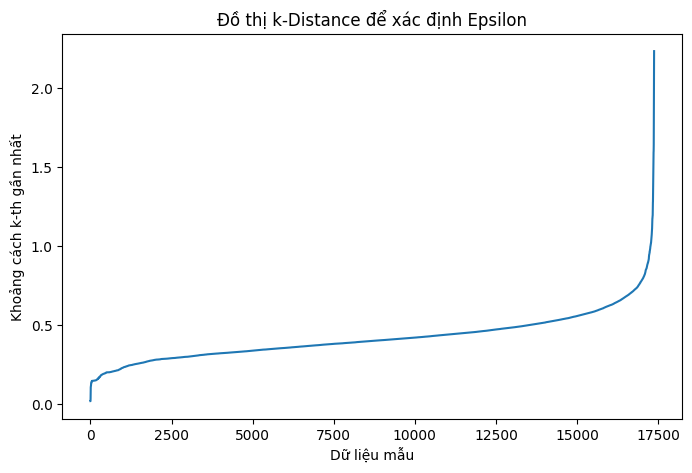

In [33]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Chọn các thuộc tính liên quan đến thời gian và điều kiện thời tiết để phân cụm
features = ['hr', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
df_selected = df[features]

# Chuẩn hóa dữ liệu bằng StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

# Xác định tham số epsilon bằng đồ thị k-distance
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

# Sắp xếp và vẽ đồ thị k-distance
distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Dữ liệu mẫu")
plt.ylabel("Khoảng cách k-th gần nhất")
plt.title("Đồ thị k-Distance để xác định Epsilon")
plt.show()


In [34]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Áp dụng DBSCAN với epsilon = 0.7 và min_samples = 5
epsilon = 0.7
dbscan = DBSCAN(eps=epsilon, min_samples=5)
df['cluster'] = dbscan.fit_predict(df_scaled)

# Kiểm tra số lượng cụm được tạo ra
num_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'].values else 0)

df_clean = df[df['cluster'] != -1]

# Tính Silhouette Score nếu có nhiều hơn một cụm hợp lệ
if num_clusters > 1:
    silhouette_avg = silhouette_score(df_scaled, df['cluster'])
else:
    silhouette_avg = None

num_clusters, silhouette_avg


(11, np.float64(-0.16885846667227297))

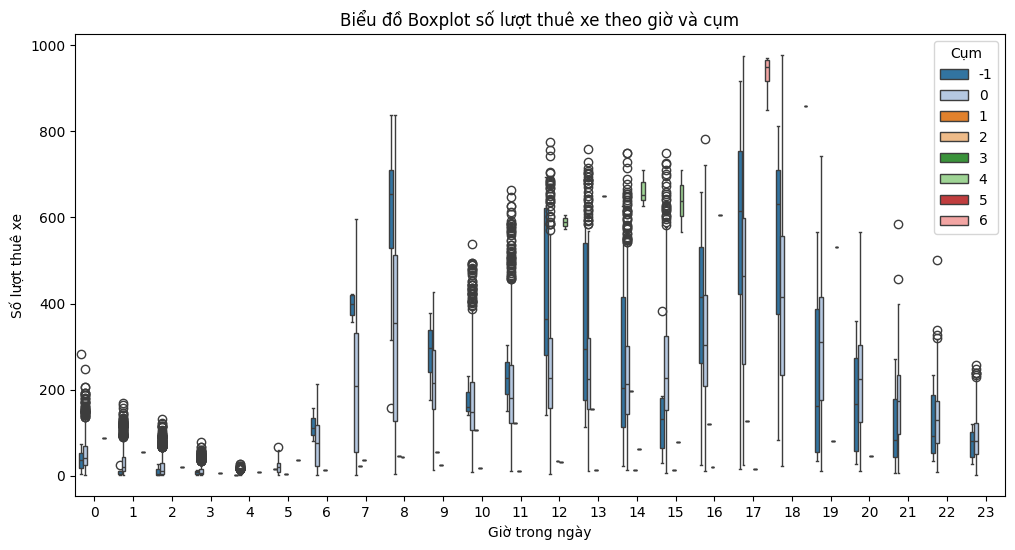

In [27]:
import seaborn as sns

# Vẽ biểu đồ phân bố số lượt thuê xe theo giờ và cụm (heatmap)
plt.figure(figsize=(12, 6))
sns.boxplot(x='hr', y='cnt', hue='cluster', data=df, palette='tab20')
plt.xlabel("Giờ trong ngày")
plt.ylabel("Số lượt thuê xe")
plt.title("Biểu đồ Boxplot số lượt thuê xe theo giờ và cụm")
plt.legend(title="Cụm")
plt.show()


In [19]:
print(df['cluster'].unique()) 
print(df['cluster'].nunique()) 


[ 0  1 -1  2  4  3  5 10  6  7  8  9]
12
